In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Hugging Face Transformers and PyTorch
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, RobertaForSequenceClassification, RobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader


# Sklearn for Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np


In [2]:
utils_path = r'C:\Users\aless\Desktop\final project 2.1\Final-Project---Luis-Augustin-Ale\utils'
sys.path.append(os.path.abspath(utils_path))

In [3]:
from custom_class_final_model import CustomRobertaModel


In [4]:
# Load the pre-trained model and tokenizer from Hugging Face
model_name = "AleOfDurin/final_retrained_model"
# Load the model and tokenizer from the Hugging Face Hub
model_custom = CustomRobertaModel.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Move the model to the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_custom.to(device)
model_custom.eval()  # Set the model to evaluation mode

CustomRobertaModel(
  (roberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
              

In [6]:
# Load your validation data (tokenized input_ids and attention_masks)
val_encodings, val_labels = torch.load(r'C:\Users\aless\Desktop\final project 2.1\val_encodings.pt')


C:\Users\aless\AppData\Local\Temp\ipykernel_32384\2492013525.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_encodings, val_labels = torch.load(r'C:\Users\aless\Desk

In [7]:
# test tokens
texts = ["Your sample text here", "Another sample text"]  # Replace with your dataset's text

# Tokenize the texts
tokenized_inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Move tokenized inputs to the device
input_ids = tokenized_inputs['input_ids'].to(device)
attention_mask = tokenized_inputs['attention_mask'].to(device)

# Debug: Print tokenized inputs
print(f"Tokenized Input IDs: {input_ids}")
print(f"Tokenized Attention Mask: {attention_mask}")


Tokenized Input IDs: tensor([[    0, 12861,  7728,  2788,   259,     2],
        [    0, 21518,  7728,  2788,     2,     1]], device='cuda:0')
Tokenized Attention Mask: tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]], device='cuda:0')


In [8]:
# Prepare DataLoader for validation
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
val_loader = DataLoader(val_dataset, batch_size=512, num_workers=8)


In [9]:
# Load your validation data (tokenized input_ids and attention_masks)
val_encodings, val_labels = torch.load(r'C:\Users\aless\Desktop\final project 2.1\val_encodings.pt')

# Prepare DataLoader for validation
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
val_loader = DataLoader(val_dataset, batch_size=512, num_workers=8)

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []
y_proba = []  # Store probabilities for ROC-AUC

# Set model to no_grad mode for inference
with torch.no_grad():
    for batch in val_loader:
        # Move batch to device (GPU/CPU)
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        
        # Run inference
        logits = model_custom(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get predicted classes
        predictions = torch.argmax(logits, dim=-1)
        probabilities = torch.softmax(logits, dim=-1)[:, 1]  # For ROC-AUC (probabilities for class 1)

        # Store predictions, true labels, and probabilities
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        y_proba.extend(probabilities.cpu().numpy())

C:\Users\aless\AppData\Local\Temp\ipykernel_32384\1558904231.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_encodings, val_labels = torch.load(r'C:\Users\aless\Desk

In [13]:
# Check the shape and some example values
print(f"Predictions (all_preds): {all_preds[:5]}")  # Print first 5 predictions
print(f"Labels (all_labels): {all_labels[:5]}")  # Print first 5 labels


Predictions (all_preds): [1, 0, 0, 1, 0]
Labels (all_labels): [0, 0, 0, 0, 0]


In [14]:
# Print a few predictions and their corresponding labels
print("Predictions sample:", all_preds[:10])
print("True labels sample:", all_labels[:10])

# Check distribution of predictions (if the model is predicting only one class)
unique_preds, counts_preds = np.unique(all_preds, return_counts=True)
pred_class_distribution = dict(zip(unique_preds, counts_preds))
print(f"Predicted Class Distribution: {pred_class_distribution}")


Predictions sample: [1, 0, 0, 1, 0, 1, 1, 1, 0, 0]
True labels sample: [0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Predicted Class Distribution: {0: 240790, 1: 228933}


In [15]:
# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
y_proba = np.array(y_proba)


In [16]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, y_proba)


In [17]:
# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.8732
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87    235207
           1       0.88      0.86      0.87    234516

    accuracy                           0.87    469723
   macro avg       0.87      0.87      0.87    469723
weighted avg       0.87      0.87      0.87    469723

Confusion Matrix:
 [[208229  26978]
 [ 32561 201955]]
ROC-AUC Score: 0.9470


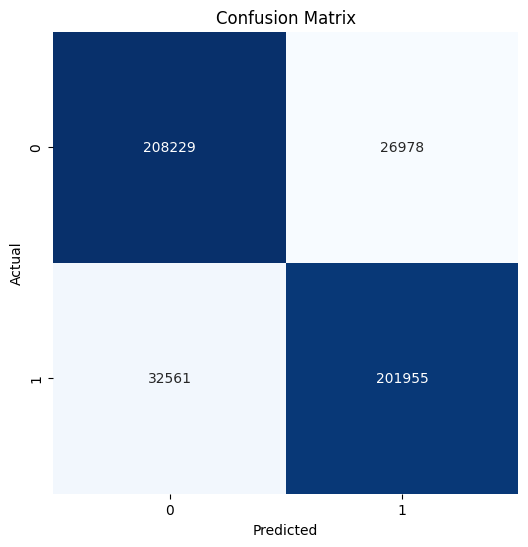

In [22]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## Metrics results

Accuracy: 0.8732  -  percentage of correctly classified instances out of the total, hence the model correctly classified about 87.32% of all sentences as either positive or negative



Classification Report  

Precision:   percentage of correctly predicted positive instances, for negative sentences (class 0): Precision = 0.86, for positive sentences (class 1): Precision = 0.88

Recall:  correctly identified sentences of a certain class out of all actual instances of that class.  For negative sentences (class 0): Recall = 0.89. For positive sentences (class 1): Recall = 0.86.

F1-Score:  harmonic mean of precision and recall  For negative sentences (class 0): F1 = 0.87 . For positive sentences (class 1): F1 = 0.87



Confusion matrix 

True Negatives (TN): 208,229 (correctly predicted negative sentences)

False Positives (FP): 26,978 (positive predictions that were actually negative)

False Negatives (FN): 32,561 (negative predictions that were actually positive)

True Positives (TP): 201,955 (correctly predicted positive sentences)



ROC-AUC Score: 0.9470    indicates how well the model can distinguish between positive and negative classes.